In [1]:
library("igraph") |> suppressPackageStartupMessages()

Warning message:
"il pacchetto 'igraph' è stato creato con R versione 4.2.3"


# Watts Strogatz - Small world network
We start by investigating the `XY - model` on the Watts strogats network:
```python
dim	
Integer constant, the dimension of the starting lattice.

size	
Integer constant, the size of the lattice along each dimension.

nei	
Integer constant, the neighborhood within which the vertices of the lattice will be connected.

p	
Real constant between zero and one, the rewiring probability.

loops	
Logical scalar, whether loops edges are allowed in the generated graph.

multiple	
Logical scalar, whether multiple edges are allowed int the generated graph.
```

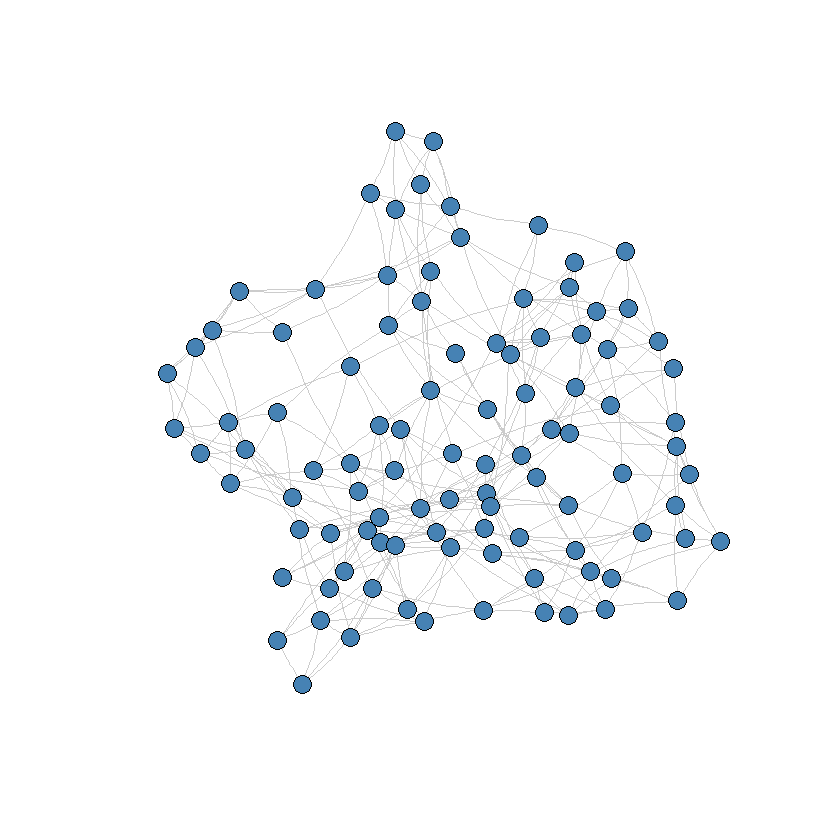

In [2]:
dim <- 1 # 1D
size <- 100
nei <- 3
p <- 0.1
g <- sample_smallworld(dim = dim, size = size, nei = nei, p = p, loops = FALSE, multiple = FALSE)
plot(g, vertex.color="steelblue", edge.curved=0.1, edge.color="gray80", vertex.label=NA, vertex.size=7)

In [3]:
get.adjacency(g)

100 x 100 sparse Matrix of class "dgCMatrix"
                                                                              
  [1,] . 1 1 1 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
  [2,] 1 . 1 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
  [3,] 1 1 . . . 1 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
  [4,] 1 . . . 1 1 . . . . . . . . . . . . . . . . . . . . . . . . 1 . . . . .
  [5,] . . . 1 . 1 1 1 . . . . . . . . . . . . . . 1 . . . . . . . . . . . . .
  [6,] . . 1 1 1 . 1 1 . . . . . . . . . . . . . . . . . . . . . . . . . . . .
  [7,] . . . . 1 1 . 1 1 1 . . . . . . . . . . . . . . . . . . . . . . . . . .
  [8,] . . . . 1 1 1 . . 1 . . . . . . . . . . . . . . . . . . . . . . . . . .
  [9,] . . . . . . 1 . . 1 . . . . . . . . . . 1 . . . . . . . . . . . . . . .
 [10,] . . . . . . 1 1 1 . 1 1 1 . . . . . . . . . . . . . . . . . . . . . . .
 [11,] . . . . . . . . . 1 . 1 1 1 . . . . . . . . . . . . . . . . . . . . . .
 [12,] 

In [4]:
# get.adjacency(g)

# $\braket{m} = \frac{\braket{M}}{N} = \frac{1}{N}|\braket{\textbf{s}}| = \frac{1}{N}|\braket{\displaystyle\sum_{i=1}^N cos \:\theta_i, \displaystyle\sum_{i=1}^N sin \:\theta_i}|$
## where $N = L \times L $
## $\braket{m^2} = \frac{\braket{M^2}}{N^2} = \frac{1}{N^2}|\braket{s_x^2+s_y^2}| = \frac{1}{N^2}|\braket{\displaystyle(\sum_{i=1}^N cos \:\theta_i)^2 + \displaystyle(\sum_{i=1}^N sin \:\theta_i)^2}|$


In [5]:
H_matrix_calc <- function(N, mat, angles.samples){
    H <- rep(0, N)
    for (i in 1:N){
        for (j in (mat[[i]])){
            # These are all the n.n.
            H[i] <- H[i] -cos(angles.samples[i] - angles.samples[j]) 
        }
    }
    co <- mean(cos(angles.samples))
    si <- mean(sin(angles.samples))
    return(list(H = H, co = co, si = si))
}

In [6]:
compute_delta_H <- function(N, mat, angles.samples, T, H){
    change_pos <- sample(N, 1)
    new_angles <- angles.samples
    new_val <- runif(1, -pi, pi)

    new_angles[change_pos] <- new_val
    
    H.new <- sum(H_matrix_calc(N, mat, new_angles)$H)/2
    delta_H <- H.new - H

    # Metropolis passage
    if (delta_H > 0){
        if (runif(n = 1, min = 0, max = 1) < exp(-delta_H/T)){
            angles.samples <- new_angles
            H <- H.new
        }
    }
    else{
        angles.samples <- new_angles
        H <- H.new
    }
    return(list(angles.samples = angles.samples, H = H))
}

In [7]:
get_specific_heat <- function(all_H, T){
    # actual.vals <- as.integer(length(all_H)/10)
    # len <- length(all_H)
    return(var(all_H)/T^2)
}

In [8]:
NN <- c(100)#, 225, 400)#, 400, 1600, 3200)
Temperature <- seq(2, 2.4, 0.025)
# probs <- seq(0, 1, 0.1)
p <- 0.2
runs <- 1:100
iter_per_step <- 1:1000
m <- c(); m.2 <- c(); m.4 <- c()
specific_heat <- c()
for (N in NN){
    g <- sample_smallworld(dim = dim, size = N, nei = nei, p = p, loops = FALSE, multiple = FALSE)
    mat <- get.adjlist(g)
    angles.samples <- runif(n = vcount(g), min = -pi, max = pi)        
    for (T in Temperature){
        magn <- c(); all_H <- c(); m_squared <- c(); m_fourth <- c()
        result <- H_matrix_calc(N = N, mat = mat, angles.samples = angles.samples)
        H_matrix <- result$H; co <- result$co; si <- result$si
        # magn <- append(magn, norm(c(co, si), type="2"))
        H <- sum(H_matrix)/2
        # all_H <- append(all_H, H)   
        for (run in runs){
            for (iter in iter_per_step){
                res <- compute_delta_H(N, mat, angles.samples, T, H)
                angles.samples <- res$angles.samples; H <- res$H
            }
            # result <- H_matrix_calc(N = N, mat = mat, angles.samples = angles.samples)
            # H_matrix <- result$H; co <- result$co; si <- result$si
            # H <- sum(H_matrix)/2
            co <- mean(cos(angles.samples))
            si <- mean(sin(angles.samples))
            all_H <- append(all_H, H)
            
            # Compute magnetization and higer orders of m
            m_temp <- c(co, si)
            m_2 <- sum(m_temp^2)
            m_4 <- m_2^2

            # Save results for each run
            magn <- append(magn, norm(m_temp, type="2"))
            m_squared <- append(m_squared, m_2)
            m_fourth <- append(m_fourth, m_4) 
        }

        specific_heat <- append(specific_heat, get_specific_heat(all_H, T))
        # Take the average for each run, so to have only one value per temperature
        m <- append(m, mean(magn))
        m.2 <- append(m.2, mean(m_squared))
        m.4 <- append(m.4, mean(m_fourth))
    }
}
U.N.T <- 1 - m.4/(3*(m.2^2))

In [9]:
m.4

[1] 0.14901135 0.13060042 0.14700178 0.11540972 0.11604708 0.10171084
 [7] 0.09493828 0.10563247 0.09012573 0.07466394 0.07879546 0.06103221
[13] 0.06108501 0.04893943 0.05098083 0.05291193 0.05123325

In [10]:
m.2

[1] 0.3687936 0.3493579 0.3707616 0.3242624 0.3253123 0.3031865 0.2935976
 [8] 0.3066325 0.2715633 0.2489595 0.2600790 0.2181059 0.2221227 0.1876227
[15] 0.1964222 0.2015442 0.2050065

In [11]:
U.N.T

[1] 0.6347995 0.6433171 0.6435392 0.6341291 0.6344794 0.6311701 0.6328740
 [8] 0.6255104 0.5926333 0.5984567 0.6116981 0.5723359 0.5873065 0.5365882
[15] 0.5595421 0.5657979 0.5936547

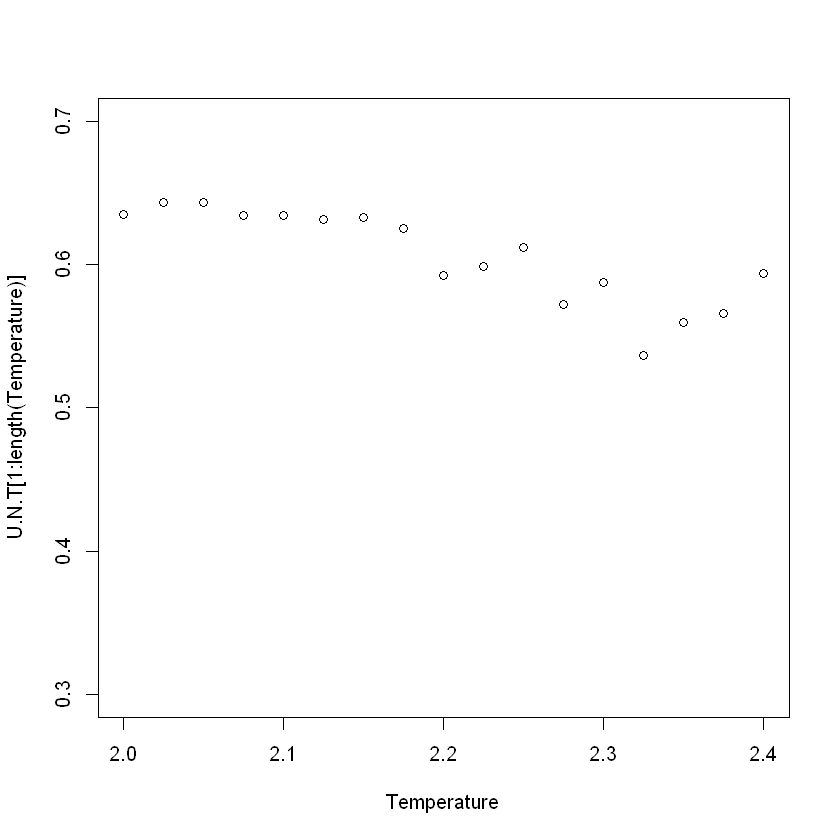

In [12]:
plot(Temperature, U.N.T[1:length(Temperature)], ylim=c(0.3, 0.7))
# points(Temperature, U.N.T[(length(Temperature)+1):(2*length(Temperature))], pch=16)    
# points(Temperature, U.N.T[(2*(length(Temperature))+1)*2:(3*length(Temperature))], pch=16)    

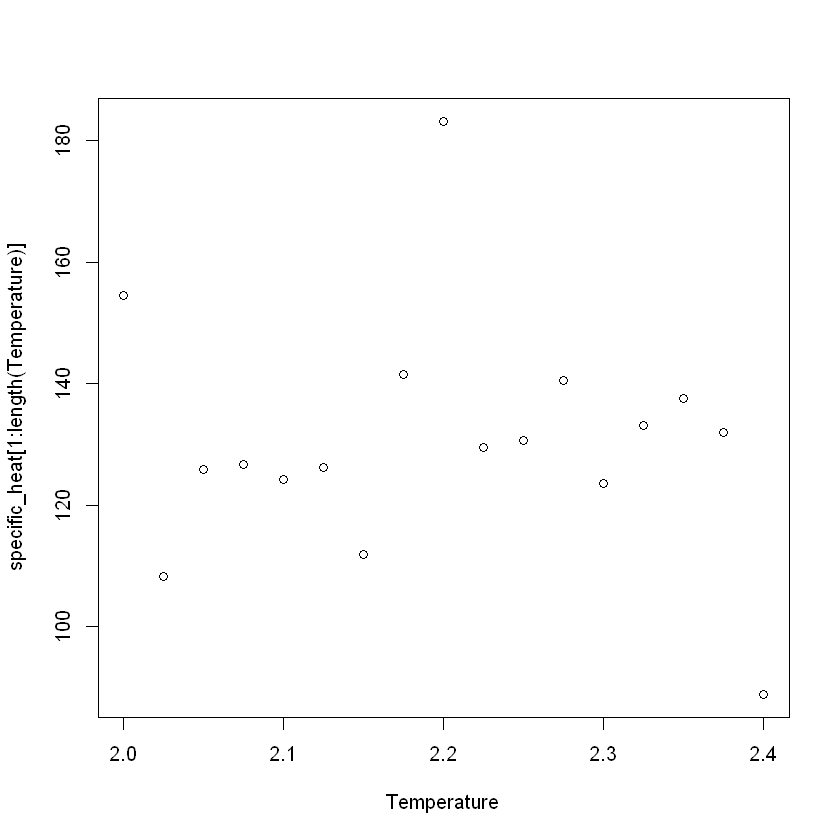

In [13]:
plot(Temperature, specific_heat[1:length(Temperature)])
# points(Temperature, specific_heat[(length(Temperature)+1):(2*length(Temperature))], pch=16)
# points(Temperature, specific_heat[(2*length(Temperature)+1):(3*length(Temperature))], pch=16)

In [14]:
all_H[1:17]

[1]  -90.62032 -117.73931 -131.88032  -89.37704  -98.89368 -106.10984
 [7] -114.41597 -144.32293  -85.65877 -106.39144 -102.86099 -118.86977
[13]  -90.23155  -77.87006  -97.36634  -81.47376 -125.16683